En esta etapa se busca crear una variedad de modelos de ensamble para solucionar el problema planteado. Para ello, deberán tomar en cuenta las siguientes consideraciones:
Incluir la optimización de hiperparámetros para los modelos más relevantes.
Utilizar algoritmos que apliquen tanto estrategias de ensamble homogéneas como heterogéneas.
Para las estrategias de stacking y/o blending, se deberán emplear los modelos individuales de mejor rendimiento obtenidos en la fase anterior.
 

Una vez que se han generado los modelos de ensamble, sintetizar los resultados en una tabla comparativa en la que se incluyan los modelos individuales de la fase previa. 
Los modelos deben ser ordenados por la métrica principal, pero el resumen debe incorporar otras métricas pertinentes.
Se deberán incluir también los tiempos de entrenamiento.
Se elige el modelo final alineado con los objetivos y necesidades del negocio.
 

Del modelo elegido, generar algunos gráficos significativos con su interpretación. La siguiente lista proporciona ejemplos, pero no es exhaustiva:
Curva ROC
Matriz de confusión
Curva de Precisión-Recall
Análisis de residuos
Gráfico de importancia de características
Tendencia y predicción (para series temporales)
Diagrama de árbol (para árboles de decisión)

## Equipo 7:

- Luis Salomon Flores Ugalde A00817435

### Importaciones

In [1]:
import os
import pickle
import pandas as pd
import subprocess
import graphviz
import matplotlib.pyplot as plt
import PIL.Image as Image

from torchsummary import summary
import seaborn as sns
import numpy as np

### Modelos

In [11]:
import torch
from pipelines.models.mlp import MLPMixer, MLPMixerV3
from utils.plot import plot_all_class_cm

from pipelines.models.modular_cnn import CustomCNN


#Selection
from pipelines.utils import TwoChannelDataset
import time
import torch
import optuna
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from pipelines.models.cnn_torch_helpers import train, train_by_ep, evaluate, accuracy


## Importación de Utilidades


In [3]:
num_workers = os.cpu_count()
print("Workers: "+ str(num_workers))
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
print("device: "+ device.type)


Workers: 12
device: mps


In [4]:

dataset_name = 'KnightX_exp_dataset'
proyect_path =  "/Users/lsfu/Desktop/MNA/Integrador/MTTX"
process_path = "/Users/lsfu/Desktop/MNA/Integrador/MTTX/data/processed"
runs_path = "/Users/lsfu/Desktop/MNA/Integrador/MTTX/data/model/runs"
os.chdir(proyect_path) 
import yaml
with open("params.yaml", "r") as ymlfile:
    params = yaml.safe_load(ymlfile)
img_size = (params["image"]["size_x"], params["image"]["size_y"])
batch_size = params["training"]["batch_size"]


In [5]:
import random

In [6]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # If using CUDA
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)  # Set

In [7]:
train_data = torch.load("/Users/lsfu/Desktop/MNA/Integrador/MTTX/data/processed/train_data_2channel_train.pt")
test_data = torch.load("/Users/lsfu/Desktop/MNA/Integrador/MTTX/data/processed/train_data_2channel_test.pt")

In [8]:

train_dataset = TwoChannelDataset(train_data)
test_dataset = TwoChannelDataset(test_data)

g = torch.Generator()
g.manual_seed(42) 

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, generator=g)  
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) 

In [9]:
study = optuna.create_study(direction="maximize")

# Valores de pruebas de Avance 4
study.enqueue_trial({
    "patch_size": 32,
    "hidden_dim": 256,
    "num_layers": 5,
    "learning_rate": 0.0003509456588467593,
    "optimizer": "Adam",
    "expansion_factor": 4,  # Now included!
    "activation": "gelu",
    "dropout": 0.0,
    "weight_decay": 0.0003999683284657429,
    "gamma": 0.1,
    "step_size": 10,
    "epochs": 30
})

# Expanded search with best values in range
def objective(trial):
    patch_size = trial.suggest_categorical("patch_size", [16, 32])
    hidden_dim = trial.suggest_categorical("hidden_dim", [128, 256])
    num_layers = trial.suggest_int("num_layers", 4, 10, step=1)
    expansion_factor = trial.suggest_categorical("expansion_factor", [2,3,4,5,6,7,8])
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "AdamW"])
    activation = trial.suggest_categorical("activation", ["gelu", "relu", "leakyrelu", "elu"])
    dropout = trial.suggest_categorical("dropout", [0.0, 0.05, 0.1, 0.2, 0.3])
    momentum = trial.suggest_categorical("momentum", [0.8, 0.85, 0.9, 0.95]) if optimizer_name == "SGD" else None
    step_size = trial.suggest_int("step_size", 5, 15, step=5)
    gamma = trial.suggest_float("gamma", 0.1, 0.9, step=0.2)

    model = MLPMixerV3(
        in_channels=2,
        img_size=224,
        num_classes=8,
        patch_size=patch_size,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        expansion_factor=expansion_factor,
        dropout=dropout,
        activation=activation
    )

    model.to(device)

    
    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum)
    else:
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    epochs = trial.suggest_int("epochs", 10, 30, step=10)

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    start_time = time.time()
    model, _ = train_by_ep(model, optimizer, train_loader, epochs, device, scheduler)
    training_time = time.time() - start_time

    model.eval()
    start_time = time.time()
    predictions, true_labels = evaluate(model, test_loader, device=device)
    inference_time = time.time() - start_time
    acc = accuracy(predictions, true_labels)

    best_acc = trial.study.user_attrs.get("best_acc", 0.0)  # Get current best accuracy
    if acc > best_acc:
        trial.study.set_user_attr("best_acc", acc)  # Update best accuracy
        torch.save(model.state_dict(), "best_model.pth")
        torch.save(optimizer.state_dict(), "best_optimizer.pth")


    trial.set_user_attr("training_time", training_time)
    trial.set_user_attr("inference_time", inference_time)

    return acc

# Run Optuna
study.optimize(objective, n_trials=30)  # Increase trials

# Get Best Model
best_trial = study.best_trial
print(f"Best Accuracy: {best_trial.value:.4f}")
print(f"Best Hyperparameters: {best_trial.params}")
print(f"Training Time: {best_trial.user_attrs['training_time']:.2f} sec")
print(f"Avg Inference Time per Sample: {best_trial.user_attrs['inference_time']:.6f} sec")



[I 2025-02-21 12:42:11,175] A new study created in memory with name: no-name-7901912b-9d8c-4e53-96d8-0d6df5024ed3
Epoch 30/30: 100%|██████████| 30/30 [00:15<00:00,  1.89epoch/s, loss=0.0282]
[I 2025-02-21 12:42:27,303] Trial 0 finished with value: 91.61676646706587 and parameters: {'patch_size': 32, 'hidden_dim': 256, 'num_layers': 5, 'expansion_factor': 4, 'learning_rate': 0.0003509456588467593, 'weight_decay': 0.0003999683284657429, 'optimizer': 'Adam', 'activation': 'gelu', 'dropout': 0.0, 'step_size': 10, 'gamma': 0.1, 'epochs': 30}. Best is trial 0 with value: 91.61676646706587.
Epoch 20/20: 100%|██████████| 20/20 [00:19<00:00,  1.01epoch/s, loss=0.0108]
[I 2025-02-21 12:42:47,137] Trial 1 finished with value: 83.23353293413173 and parameters: {'patch_size': 16, 'hidden_dim': 256, 'num_layers': 4, 'expansion_factor': 5, 'learning_rate': 0.0007694290699193526, 'weight_decay': 1.5861482896850905e-06, 'optimizer': 'SGD', 'activation': 'leakyrelu', 'dropout': 0.1, 'momentum': 0.8, 'st

Best Accuracy: 91.6168
Best Hyperparameters: {'patch_size': 32, 'hidden_dim': 256, 'num_layers': 5, 'expansion_factor': 4, 'learning_rate': 0.0003509456588467593, 'weight_decay': 0.0003999683284657429, 'optimizer': 'Adam', 'activation': 'gelu', 'dropout': 0.0, 'step_size': 10, 'gamma': 0.1, 'epochs': 30}
Training Time: 15.94 sec
Avg Inference Time per Sample: 0.080733 sec


Best Accuracy: 91.0180
Best Hyperparameters: {'patch_size': 32, 'hidden_dim': 256, 'num_layers': 5, 'expansion_factor': 7, 'learning_rate': 0.00029861712520748337, 'optimizer': 'Adam', 'activation': 'leakyrelu', 'dropout': 0.0, 'epochs': 30}
Training Time: 36.16 sec
Avg Inference Time per Sample: 0.127862 sec

Best Accuracy: 91.0180
Best Hyperparameters: {'patch_size': 32, 'hidden_dim': 128, 'num_layers': 8, 'expansion_factor': 8, 'learning_rate': 0.00025634971631276166, 'optimizer': 'Adam', 'activation': 'leakyrelu', 'dropout': 0.05, 'epochs': 30}
Training Time: 19.02 sec
Avg Inference Time per Sample: 0.078386 sec


Trial 0 finished with value: 91.61676646706587 and parameters: {'patch_size': 32, 'hidden_dim': 256, 'num_layers': 5, 'expansion_factor': 4, 'learning_rate': 0.0003509456588467593, 'weight_decay': 0.0003999683284657429, 'optimizer': 'Adam', 'activation': 'gelu', 'dropout': 0.0, 'step_size': 10, 'gamma': 0.1, 'epochs': 30}. Best is trial 0 with value: 91.61676646706587.


In [12]:
best_trial.params

{'patch_size': 32,
 'hidden_dim': 256,
 'num_layers': 5,
 'expansion_factor': 4,
 'learning_rate': 0.0003509456588467593,
 'weight_decay': 0.0003999683284657429,
 'optimizer': 'Adam',
 'activation': 'gelu',
 'dropout': 0.0,
 'step_size': 10,
 'gamma': 0.1,
 'epochs': 30}

In [20]:
import json

with open("best_hyperparams.json", "w") as f:
    json.dump(best_trial.params, f, indent=4)

In [11]:
best_acc = 0.0 
best_model_state = None  

num_runs = 20  

for run in range(num_runs):

    best_model = MLPMixerV3(
        in_channels=2,
        img_size=224,
        num_classes=8,
        patch_size=32,
        hidden_dim=256,
        num_layers=5,
        expansion_factor=4,
        dropout=0.0,
        activation='gelu'
    )
       

    optimizer = optim.Adam(best_model.parameters(), lr=0.0003509456588467593, weight_decay=0.0003999683284657429)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    _, epochs = train_by_ep(best_model, optimizer, train_loader, 30, device, scheduler)
    best_model.eval()
    predictions, true_labels = evaluate(best_model, test_loader, device=device)
    acc = accuracy(predictions, true_labels)

    if acc > best_acc:
        best_acc = acc
        best_model_state = best_model.state_dict().copy()  
        torch.save(best_model_state, "best_runs_model.pth") 

print(f"\nBest Accuracy Achieved Hyperparameters only: {best_acc:.4f}")


Epoch 30/30: 100%|██████████| 30/30 [00:16<00:00,  1.84epoch/s, loss=0.026] 


Best Accuracy Achieved Hyperparameters only: 91.0180


Trial 3 finished with value: 85.02994011976048 and parameters: {'model': 'CustomCNN_3', 'channel1': 32, 'channel2': 128, 'channel3': 384, 'learning_rate': 0.0042736502037543965, 'optimizer': 'SGD', 'epochs': 30}. Best is trial 3 with value: 85.02994011976048.

In [18]:
study = optuna.create_study(direction="maximize")
from pipelines.models.modular_cnn import CustomCNN_3, CustomCNN

# Valores de pruebas de Avance 4
study.enqueue_trial({
    "channel1": 32,
    "channel2": 128,
    "learning_rate": 1e-4,
    "optimizer": "Adam",
    "weight_decay": 1e-6,
    "gamma": 0.1,
    "step_size": 10,
    "epochs": 15
})

# Expanded search with best values in range
def objective(trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "AdamW"])
    momentum = trial.suggest_categorical("momentum", [0.8, 0.85, 0.9, 0.95]) if optimizer_name == "SGD" else None
    step_size = trial.suggest_int("step_size", 5, 15, step=5)
    gamma = trial.suggest_float("gamma", 0.1, 0.9, step=0.2)
    
    model = CustomCNN(
        in_channels=2,
        channel1=trial.suggest_int("channel1", 32, 128, step=32),
        channel2=trial.suggest_int("channel2", 64, 256, step=64),
        out_features=8,
        img_size=(224, 224)
    )

    model.to(device)

    
    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum)
    else:
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    epochs = trial.suggest_int("epochs", 10, 15, step=5)

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    start_time = time.time()
    model, _ = train_by_ep(model, optimizer, train_loader, epochs, device, scheduler)
    training_time = time.time() - start_time

    model.eval()
    start_time = time.time()
    predictions, true_labels = evaluate(model, test_loader, device=device)
    inference_time = time.time() - start_time
    acc = accuracy(predictions, true_labels)

    best_acc = trial.study.user_attrs.get("best_acc", 0.0)  # Get current best accuracy
    if acc > best_acc:
        trial.study.set_user_attr("best_acc", acc)  # Update best accuracy
        torch.save(model.state_dict(), "best_cnn_model.pth")
        torch.save(optimizer.state_dict(), "best_cnn_optimizer.pth")


    trial.set_user_attr("training_time", training_time)
    trial.set_user_attr("inference_time", inference_time)

    return acc

# Run Optuna
study.optimize(objective, n_trials=10)  # Increase trials

# Get Best Model
best_trial = study.best_trial
print(f"Best Accuracy: {best_trial.value:.4f}")
print(f"Best Hyperparameters: {best_trial.params}")
print(f"Training Time: {best_trial.user_attrs['training_time']:.2f} sec")
print(f"Avg Inference Time per Sample: {best_trial.user_attrs['inference_time']:.6f} sec")

[I 2025-02-21 13:46:53,282] A new study created in memory with name: no-name-a35df4c1-bda7-4b65-95de-c671e7e128f5
Epoch 15/15: 100%|██████████| 15/15 [00:46<00:00,  3.12s/epoch, loss=0.000945]
[I 2025-02-21 13:47:40,464] Trial 0 finished with value: 79.04191616766467 and parameters: {'learning_rate': 0.0001, 'weight_decay': 1e-06, 'optimizer': 'Adam', 'step_size': 10, 'gamma': 0.1, 'channel1': 32, 'channel2': 128, 'epochs': 15}. Best is trial 0 with value: 79.04191616766467.
Epoch 15/15: 100%|██████████| 15/15 [02:30<00:00, 10.05s/epoch, loss=0.023] 
[I 2025-02-21 13:50:12,077] Trial 1 finished with value: 83.23353293413173 and parameters: {'learning_rate': 0.0025528487768926543, 'weight_decay': 0.00014631362388707416, 'optimizer': 'AdamW', 'step_size': 10, 'gamma': 0.5, 'channel1': 128, 'channel2': 128, 'epochs': 15}. Best is trial 1 with value: 83.23353293413173.
Epoch 15/15: 100%|██████████| 15/15 [01:16<00:00,  5.10s/epoch, loss=0.0213]
[I 2025-02-21 13:51:28,841] Trial 2 finished 

Best Accuracy: 83.2335
Best Hyperparameters: {'learning_rate': 0.0025528487768926543, 'weight_decay': 0.00014631362388707416, 'optimizer': 'AdamW', 'step_size': 10, 'gamma': 0.5, 'channel1': 128, 'channel2': 128, 'epochs': 15}
Training Time: 150.76 sec
Avg Inference Time per Sample: 0.714116 sec


In [21]:
best_trial.params

{'learning_rate': 0.0025528487768926543,
 'weight_decay': 0.00014631362388707416,
 'optimizer': 'AdamW',
 'step_size': 10,
 'gamma': 0.5,
 'channel1': 128,
 'channel2': 128,
 'epochs': 15}

In [22]:
with open("best_cnn_hyperparams.json", "w") as f:
    json.dump(best_trial.params, f, indent=4)

In [12]:
import os
import torch
import pickle
import json
import time
from sklearn.metrics import confusion_matrix
from pipelines.utils.metrics import compute_classification_metrics, normal_cm, get_predictions_and_probs
label_map = {0: "angry", 1: "contempt", 2: "disgust", 3: "fear", 4: "happy", 5: "neutral", 6: "sad", 7: "surprise"}
label_names = ["angry","contempt","disgust", "fear","happy","neutral", "sad","surprise"]

def load_model_and_compute_metrics(test_loader, device="mps"):
    # Define model file names
    main_model_name = "best_model"  # MLPMixerV3
    second_model_name = "best_cnn_model"  # CustomCNN
    
    # Paths for model weights
    main_model_path = f"{main_model_name}.pth"
    second_model_path = f"{second_model_name}.pth"
    
    # Load hyperparameters from JSON files
    with open("best_hyperparams.json", "r") as f:
        main_hyperparams = json.load(f)

    with open("best_cnn_hyperparams.json", "r") as f:
        second_hyperparams = json.load(f)
    
    # Initialize MLPMixerV3 model with loaded hyperparameters
    main_model = MLPMixerV3(
        in_channels=2,
        img_size=224,
        num_classes=8,
        patch_size=main_hyperparams["patch_size"],
        hidden_dim=main_hyperparams["hidden_dim"],
        num_layers=main_hyperparams["num_layers"],
        expansion_factor=main_hyperparams["expansion_factor"],
        dropout=main_hyperparams["dropout"],
        activation=main_hyperparams["activation"]
    )

    second_model = CustomCNN(
        in_channels=2,
        channel1=second_hyperparams["channel1"],
        channel2=second_hyperparams["channel2"],
        out_features=8,
        img_size=(224, 224)
    )

    # Load model weights
    main_model.load_state_dict(torch.load(main_model_path, map_location=device))
    second_model.load_state_dict(torch.load(second_model_path, map_location=device))

    main_model.to(device).eval()
    second_model.to(device).eval()

    # Compute metrics for a given model
    def compute_metrics(model):
        start_time = time.time()
        predictions, true_labels = evaluate(model, test_loader, device=device)
        inference_time = time.time() - start_time

        conf_matrix = confusion_matrix(true_labels, predictions)
        df_clases, df_macro = compute_classification_metrics(conf_matrix, label_map)

        # Add accuracy and inference time to df_macro
        df_macro.loc["Accuracy"] = accuracy(predictions, true_labels)
        df_macro.loc["Inference Time"] = inference_time

        return conf_matrix, df_clases, df_macro

    # Compute metrics for both models
    main_cm, main_classes_df, main_macro_df = compute_metrics(main_model)
    second_cm, second_classes_df, second_macro_df = compute_metrics(second_model)

    # Pack computed metrics
    main_data = (main_cm, main_classes_df, main_macro_df)
    second_data = (second_cm, second_classes_df, second_macro_df)

    return main_model, second_model, main_data, second_data


In [13]:
main_model, second_model, main_data, second_data = load_model_and_compute_metrics(test_loader, device=device)

In [14]:
second_cm, second_classes_df, second_macro_df = second_data
main_cm, main_classes_df, main_macro_df = main_data

# Stacking MLP + CNN simple

### 1- Predicciones para Stacking

In [15]:
predictions_main, train_true_labels = evaluate(main_model, test_loader, device=device)
predictions_second, _ = evaluate(second_model, test_loader, device=device)
stacked_features_train = np.column_stack((predictions_main, predictions_second))  # Train feature matrix
stacked_labels_train = np.array(train_true_labels)  # True labels

### 2- Meta-learner

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import joblib

# Split the stacked dataset (80% train, 20% validation) - Still on train data
X_train, X_val, y_train, y_val = train_test_split(stacked_features_train, stacked_labels_train, test_size=0.2, random_state=42)

# Initialize both meta-learners
meta_learner_rf = RandomForestClassifier(n_estimators=100, random_state=42)
meta_learner_lr = LogisticRegression(max_iter=500)

# Train both models
meta_learner_rf.fit(X_train, y_train)
meta_learner_lr.fit(X_train, y_train)

# Save trained models
joblib.dump(meta_learner_rf, "meta_learner_rf.pkl")
joblib.dump(meta_learner_lr, "meta_learner_lr.pkl")

print("Both meta-learners trained and saved.")



Both meta-learners trained and saved.


### Evaluate Meta-Learners

In [17]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Load the saved models
meta_learner_rf = joblib.load("meta_learner_rf.pkl")
meta_learner_lr = joblib.load("meta_learner_lr.pkl")

# Predict on validation set (from train data split)
rf_preds = meta_learner_rf.predict(X_val)
lr_preds = meta_learner_lr.predict(X_val)

# Compute accuracies
rf_acc = accuracy_score(y_val, rf_preds)
lr_acc = accuracy_score(y_val, lr_preds)

print(f"Random Forest Stacking Accuracy on Validation Set: {rf_acc:.4f}")
print(f"Logistic Regression Stacking Accuracy on Validation Set: {lr_acc:.4f}")



Random Forest Stacking Accuracy on Validation Set: 0.8824
Logistic Regression Stacking Accuracy on Validation Set: 0.7941


### Mejor Mejor Stack

In [18]:
# Extract predictions from both models using the actual test set
test_predictions_main, test_true_labels = evaluate(main_model, test_loader, device=device)
test_predictions_second, _ = evaluate(second_model, test_loader, device=device)

# Stack test predictions
stacked_features_test = np.column_stack((test_predictions_main, test_predictions_second))  # Test feature matrix
stacked_labels_test = np.array(test_true_labels)  # True labels

# Load the best meta-learner (choose based on validation accuracy)
if rf_acc > lr_acc:
    best_meta_learner = meta_learner_rf
    best_meta_name = "Random Forest"
else:
    best_meta_learner = meta_learner_lr
    best_meta_name = "Logistic Regression"

# Predict on the test set
stacked_test_preds = best_meta_learner.predict(stacked_features_test)

# Compute final test accuracy
test_acc = accuracy_score(stacked_labels_test, stacked_test_preds)
test_cm = confusion_matrix(stacked_labels_test, stacked_test_preds)

print(f"Final Stacking Accuracy ({best_meta_name}): {test_acc:.4f}")


Final Stacking Accuracy (Random Forest): 0.9701


In [19]:
df_rf_clases, df_rf_macro = compute_classification_metrics(test_cm, label_map)

# Blending

In [20]:
import torch
import torch.nn.functional as F
import numpy as np

def evaluate_with_probs(model, data_loader, device='mps'):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device=device)
    model.eval()

    all_probs = []
    predictions = []
    true_labels = []

    with torch.no_grad():
        for xi, yi in data_loader:
            xi = xi.to(device, dtype=torch.float32)
            yi = yi.to(device, dtype=torch.long)

            scores = model(xi)
            probs = F.softmax(scores, dim=1)  # Convert logits to softmax probabilities
            _, predicted = torch.max(scores, 1)

            all_probs.extend(probs.cpu().numpy())  # Store softmax probabilities
            predictions.extend(predicted.cpu().tolist())  # Store predicted classes
            true_labels.extend(yi.cpu().tolist())  # Store true labels

    return all_probs, predictions, true_labels

### 1 - Probabilidades Softmax

In [21]:
test_probs_main, test_preds_main, test_true_labels = evaluate_with_probs(main_model, test_loader, device=device)

test_probs_second, test_preds_second, _ = evaluate_with_probs(second_model, test_loader, device=device)


In [22]:
target_class = 0  

### 2 - Blending de probabilidades

In [23]:
import numpy as np

# Define initial blending weights (default: 80% MLP Mixer, 20% CNN)
alpha = 0.8  # Weight for MLP Mixer
beta = 1 - alpha  # Weight for CNN

# Convert lists to numpy arrays
test_probs_main = np.array(test_probs_main)
test_probs_second = np.array(test_probs_second)

# Compute blended probabilities
blended_probs = (alpha * test_probs_main) + (beta * test_probs_second)

# Convert to final class predictions
blended_preds = np.argmax(blended_probs, axis=1)


### 3 - Evaluación blending
Podemos terminar aquí

In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Compute accuracy
blended_acc = accuracy_score(test_true_labels, blended_preds)

# Compute confusion matrix
blended_cm = confusion_matrix(test_true_labels, blended_preds)

print(f"Blending Accuracy: {blended_acc:.4f}")
print("Blended Model Confusion Matrix:\n", blended_cm)


Blending Accuracy: 0.9042
Blended Model Confusion Matrix:
 [[15  0  1  1  0  1  0  2]
 [ 1 14  0  0  2  0  0  0]
 [ 0  0 14  0  2  0  0  0]
 [ 0  0  0 17  0  0  2  1]
 [ 0  0  0  0 24  0  1  0]
 [ 0  0  0  0  0 16  0  0]
 [ 0  1  1  0  0  0 31  0]
 [ 0  0  0  0  0  0  0 20]]


### 4 - Optimización en clase conflictiva

In [25]:
from sklearn.metrics import recall_score, precision_score
best_alpha = 0.9  
best_score = 0 

for alpha in np.linspace(0, 1, 11):  # Try values from 0.0 to 1.0
    beta = 1 - alpha

    # Start with full MLP Mixer predictions (default)
    blended_probs = np.array(test_probs_main)  # Keep all classes 100% MLP Mixer

    # Blend only class 0
    blended_probs[:, target_class] = (alpha * test_probs_main[:, target_class]) + (beta * test_probs_second[:, target_class])

    # Convert probabilities to class predictions
    blended_preds = np.argmax(blended_probs, axis=1)

    # Compute recall for the target class
    recall = recall_score(test_true_labels, blended_preds, average=None)[target_class]

    if recall > best_score:  # Use recall as the main target metric
        best_score = recall
        best_alpha = alpha

print(f"Best Blending Weight for Target Class {target_class}: {best_alpha:.2f}")
print(f"Best Class Recall: {best_score:.4f}")

Best Blending Weight for Target Class 0: 0.20
Best Class Recall: 0.8000


### 6 - Blending optimización por clase...
No es muy efectivo cuando el modelo que se le da es inferior en esa misma clase. Si fuera peor en todas las demás clases pero muy bueno únicamente en esta clase podría tener valor hacer blending por clase. 

In [28]:
from sklearn.metrics import classification_report

blended_preds = np.argmax((best_alpha * np.array(test_probs_main)) + ((1 - best_alpha) * np.array(test_probs_second)), axis=1)

print(accuracy_score(test_true_labels, blended_preds))


0.8323353293413174


In [29]:
df_bl_clases, df_bl_macro = compute_classification_metrics(blended_cm, label_map)


{1: 'custom_cnn',
 2: 'mlp',
 3: 'deep_capsule',
 4: 'capsule',
 5: 'dense',
 6: 'densenet',
 7: 'efficientnet',
 8: 'mobilenet',
 9: 'resnet18',
 10: 'vgg16',
 11: 'vit'}

In [30]:
process_path = "/Users/lsfu/Desktop/MNA/Integrador/MTTX/data/processed"

model_names = list(params["models"].keys())

model_name_dict = {i + 1: name for i, name in enumerate(model_names)}

def load_metrics(index):
    model_name = model_name_dict[index]
    cm_file = f"conf_matrix_{model_name}.pkl"
    metrics_file = f"metrics_{model_name}.pkl"
    with open(os.path.join(process_path, cm_file), "rb") as f:
        cm = pickle.load(f)
    with open(os.path.join(process_path, metrics_file), "rb") as f:
        classes_df, macro_df = pickle.load(f)
    return classes_df, macro_df, cm

def save_model_metrics(model_name, cm, macro_df, classes_df, base_models=None):
    metrics_dict = {
        "model_name": model_name,
        "macro_metrics": macro_df.to_dict(),
        "class_metrics": classes_df.to_dict(),
        "confusion_matrix": cm.tolist(), 
        "base_models": base_models 
    }
    output_path = os.path.join("notebooks/results", f"metrics_{model_name}.json")
    with open(output_path, "w") as f:
        json.dump(metrics_dict, f, indent=4)


In [33]:
for index in model_name_dict.keys():
    classes_df, macro_df, cm = load_metrics(index)
    save_model_metrics(model_name_dict[index], cm, macro_df, classes_df)
    

In [34]:
save_model_metrics("MLP_h", main_cm, main_macro_df, main_classes_df)
save_model_metrics("CNN_h", second_cm, second_macro_df, second_classes_df)

save_model_metrics("stacking", test_cm, df_rf_macro, df_rf_clases, base_models=["MLP_h", "CNN_h"])

# Save Blending Metrics
save_model_metrics("blending", blended_cm, df_bl_macro, df_bl_clases, base_models=["MLP_h", "CNN_h"])


# Comparación de Modelos

El tiempo de inferencia (es de 21 batches de 32) stacking y blending solo se sumaron con sus respectivos modelos.
El modelo seleccionado para el stacking y blending no es el mejor que pudo salir de la cnn la CNN_3 obtuvo mejores resultados por si sola a comparación de la simple una sola capa más de conv y una exploración de parámetros llega la Accuracy a 86.5 pero para simplificar los efectos y el tiempo decidí ver los resultados con la implementación original simple de la CNN. No se hicieron cambios en su arquitectura.

### Tabla Comparativa de Modelos

| Modelo       | Accuracy (%) | Precision | Recall | F1 Score | MCC  | Tiempo de Entrenamiento (s) | Tiempo de Inferencia (s) |
|-------------|-------------|-----------|--------|----------|------|-----------------------------|--------------------------|
| **Stacking**     | **96.72**  | 0.9682    | 0.9672 | 0.9673   | 0.9658 | -                           | 1.3227                   |
| **MLP_h**        | 91.62      | 0.9237    | 0.9109 | 0.9120   | 0.9042 | 15.94                       | 0.7991                   |
| **VGG16**        | 91.62      | 0.9131    | 0.9155 | 0.9108   | 0.9042 | 606.40                      | 14.19                    |
| **Blending**     | 89.97      | 0.9087    | 0.8997 | 0.9011   | 0.8905 | -                           | 1.0197                   |
| **MLP**          | 86.83      | 0.8749    | 0.8581 | 0.8546   | 0.8494 | 10.84                       | 0.1850                   |
| **Deep Capsule** | 83.83      | 0.8465    | 0.8256 | 0.8240   | 0.8152 | 419.12                      | 1.2344                   |
| **CNN_h**        | 83.23      | 0.8345    | 0.8243 | 0.8237   | 0.8083 | 170.75                      | 0.5236                   |
| **Capsule**      | 76.65      | 0.7734    | 0.7557 | 0.7551   | 0.7331 | 1547.12                     | 4.4522                   |
| **Custom CNN**   | 78.44      | 0.7912    | 0.7712 | 0.7725   | 0.7536 | 26.55                       | 0.2206                   |
| **Densenet**     | 62.87      | 0.6992    | 0.5649 | 0.5341   | 0.5757 | 389.44                      | 22.92                    |
| **ViT**          | 55.69      | 0.5627    | 0.5528 | 0.5520   | 0.4936 | 608.90                      | 6.19                     |
| **EfficientNet** | 44.31      | 0.4682    | 0.4293 | 0.4168   | 0.3636 | 571.54                      | 12.75                    |
| **MobileNet**    | 38.92      | 0.4669    | 0.3445 | 0.3089   | 0.3020 | 304.46                      | 6.71                     |
| **ResNet18**     | 29.94      | 0.3300    | 0.2879 | 0.2666   | 0.1993 | 223.63                      | 4.93                     |
| **Dense**        | 28.14      | 0.2407    | 0.2619 | 0.2014   | 0.1788 | 1148.27                     | 2.16                     |

### Hyperparametros de la MLP
Primero, llegamos justamente al accuracy de la **VGG16**! con una que otra mejora o equivalencía en otras, el modelo muestra una mejora considerable en tiempo de respuesta.

### Selección del Modelo Final
Con otro método de Ensamble podríamos ver aún mejores resultados, pero requerimos más datos. Podemos simplemente dividirlos de una manera diferente pero creo que el tercer método con diferentes variaciones del mismo modelo de MLP se beneficiaria con más varianza de datos. Varianza siendo personas.

El modelo **Stacking** obtuvo el mejor rendimiento con un **96.72% de precisión**, la mejor combinación de **Recall (96.72%) y Precision (96.82%)**, y el **mejor MCC (0.9658)**. Su tiempo de inferencia de **1.32 s** sigue siendo competitivo en comparación con otros modelos de alto rendimiento.

El segundo mejor modelo es **MLP_h**, que alcanzó **91.62% de precisión** con tiempos de inferencia significativamente más bajos (**0.799 s**). Sin embargo, el modelo de **Stacking** ofrece una mejora significativa en todas las métricas clave sin sacrificar demasiado en tiempo de inferencia.

Por lo tanto, **Stacking es seleccionado como el modelo final**, alineado con los objetivos de maximizar precisión y estabilidad en el rendimiento.

# Análisis grafico de Stacking 

In [37]:
def plot_confuse_matrix(confuse_matrix, class_labels=None):
    cm = confuse_matrix
    num_classes = cm.shape[0]
    if class_labels is None:
        class_labels = [f"Clase {i}" for i in range(num_classes)]

    cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100  # Normalize per class

    cell_labels = [[f"{cm[i, j]}\n{cm_percent[i, j]:.1f}%" for j in range(num_classes)] for i in range(num_classes)]

    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(cm_percent, annot=np.array(cell_labels), fmt='', cmap="Pastel1", xticklabels=class_labels,
                     yticklabels=class_labels, cbar=False)
    ax.set_xlabel("Predicted Class")
    ax.set_ylabel("Actual Class")
    ax.set_title("Confusion Matrix with Counts and Percentages")
    plt.show()

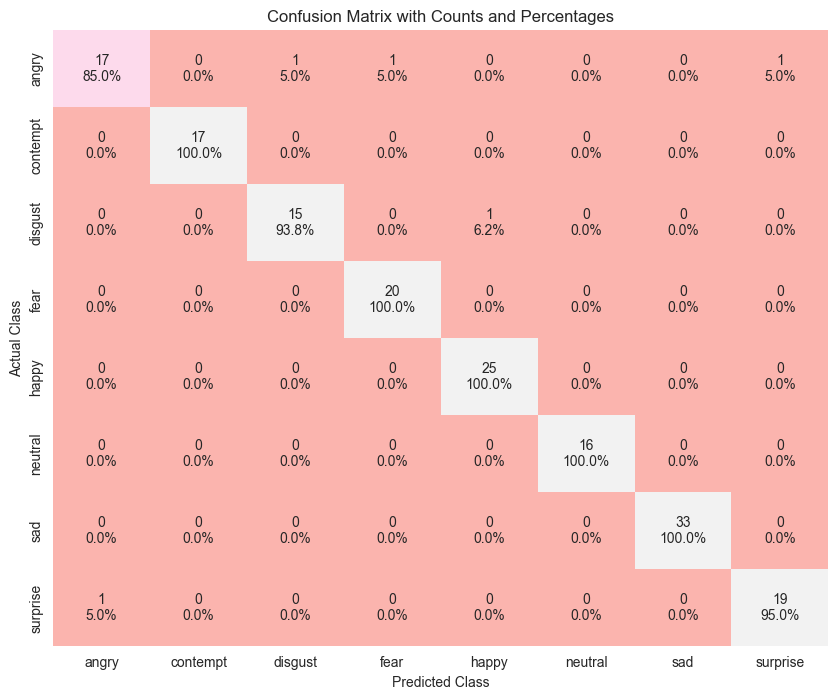

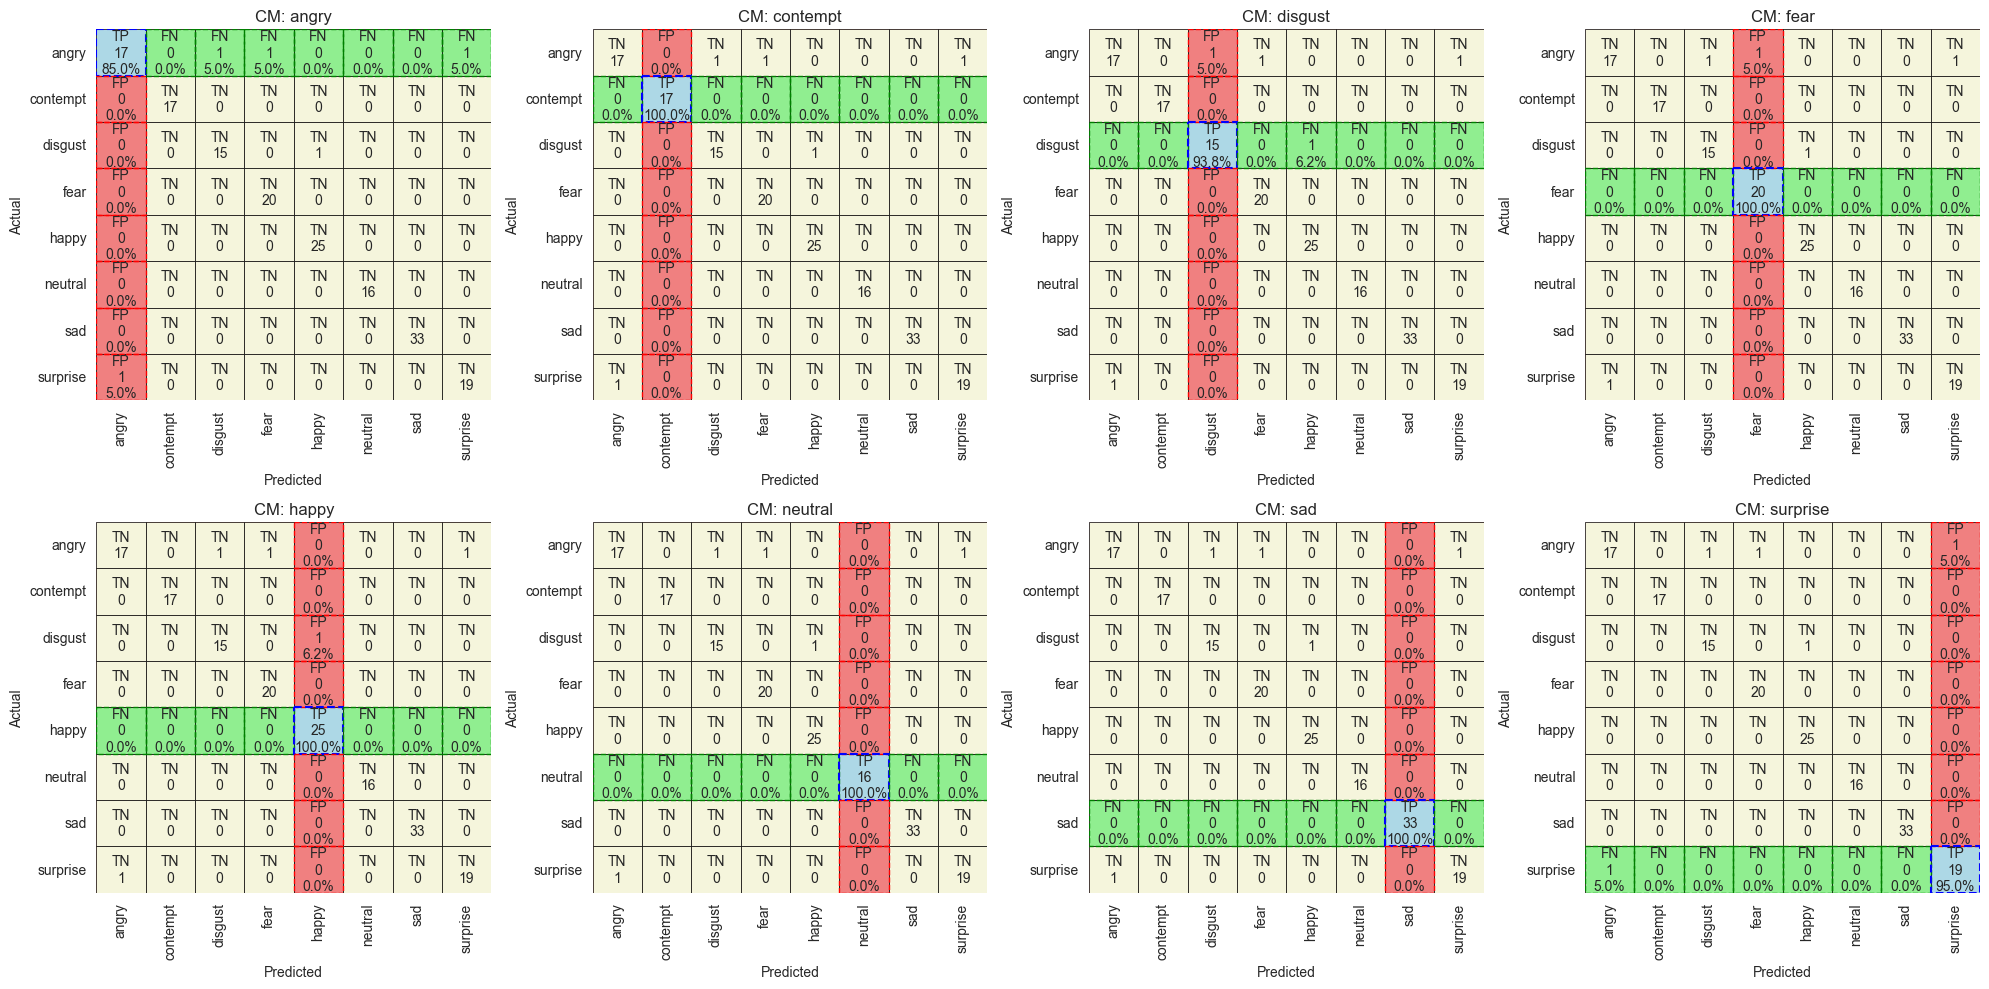

,Recall (Sensitivity),Miss Rate,Specificity (Selectivity),Fallout,Precision,False Discovery Rate (FDR),Negative Predictive Value (NPV),False Omission Rate (FOR),F1 Score
Class,,,,,,,,,
angry,0.8500,0.1500,0.993197,0.006803,0.944444,0.055556,0.979866,0.020134,0.894737
contempt,1.0000,0.0000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
disgust,0.9375,0.0625,0.993377,0.006623,0.937500,0.062500,0.993377,0.006623,0.937500
fear,1.0000,0.0000,0.993197,0.006803,0.952381,0.047619,1.000000,0.000000,0.975610
happy,1.0000,0.0000,0.992958,0.007042,0.961538,0.038462,1.000000,0.000000,0.980392
neutral,1.0000,0.0000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
sad,1.0000,0.0000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
surprise,0.9500,0.0500,0.993197,0.006803,0.950000,0.050000,0.993197,0.006803,0.950000


                                    Valor
Recall (Sensitivity)             0.967188
Miss Rate                        0.032813
Specificity (Selectivity)        0.995741
Fallout                          0.004259
Precision                        0.968233
False Discovery Rate (FDR)       0.031767
Negative Predictive Value (NPV)  0.995805
False Omission Rate (FOR)        0.004195
F1 Score                         0.967280
MCC                              0.965783


In [38]:
plot_confuse_matrix(test_cm, label_names)
plot_all_class_cm(test_cm, label_names, per_row=4)
display(df_rf_clases)
print(df_rf_macro)

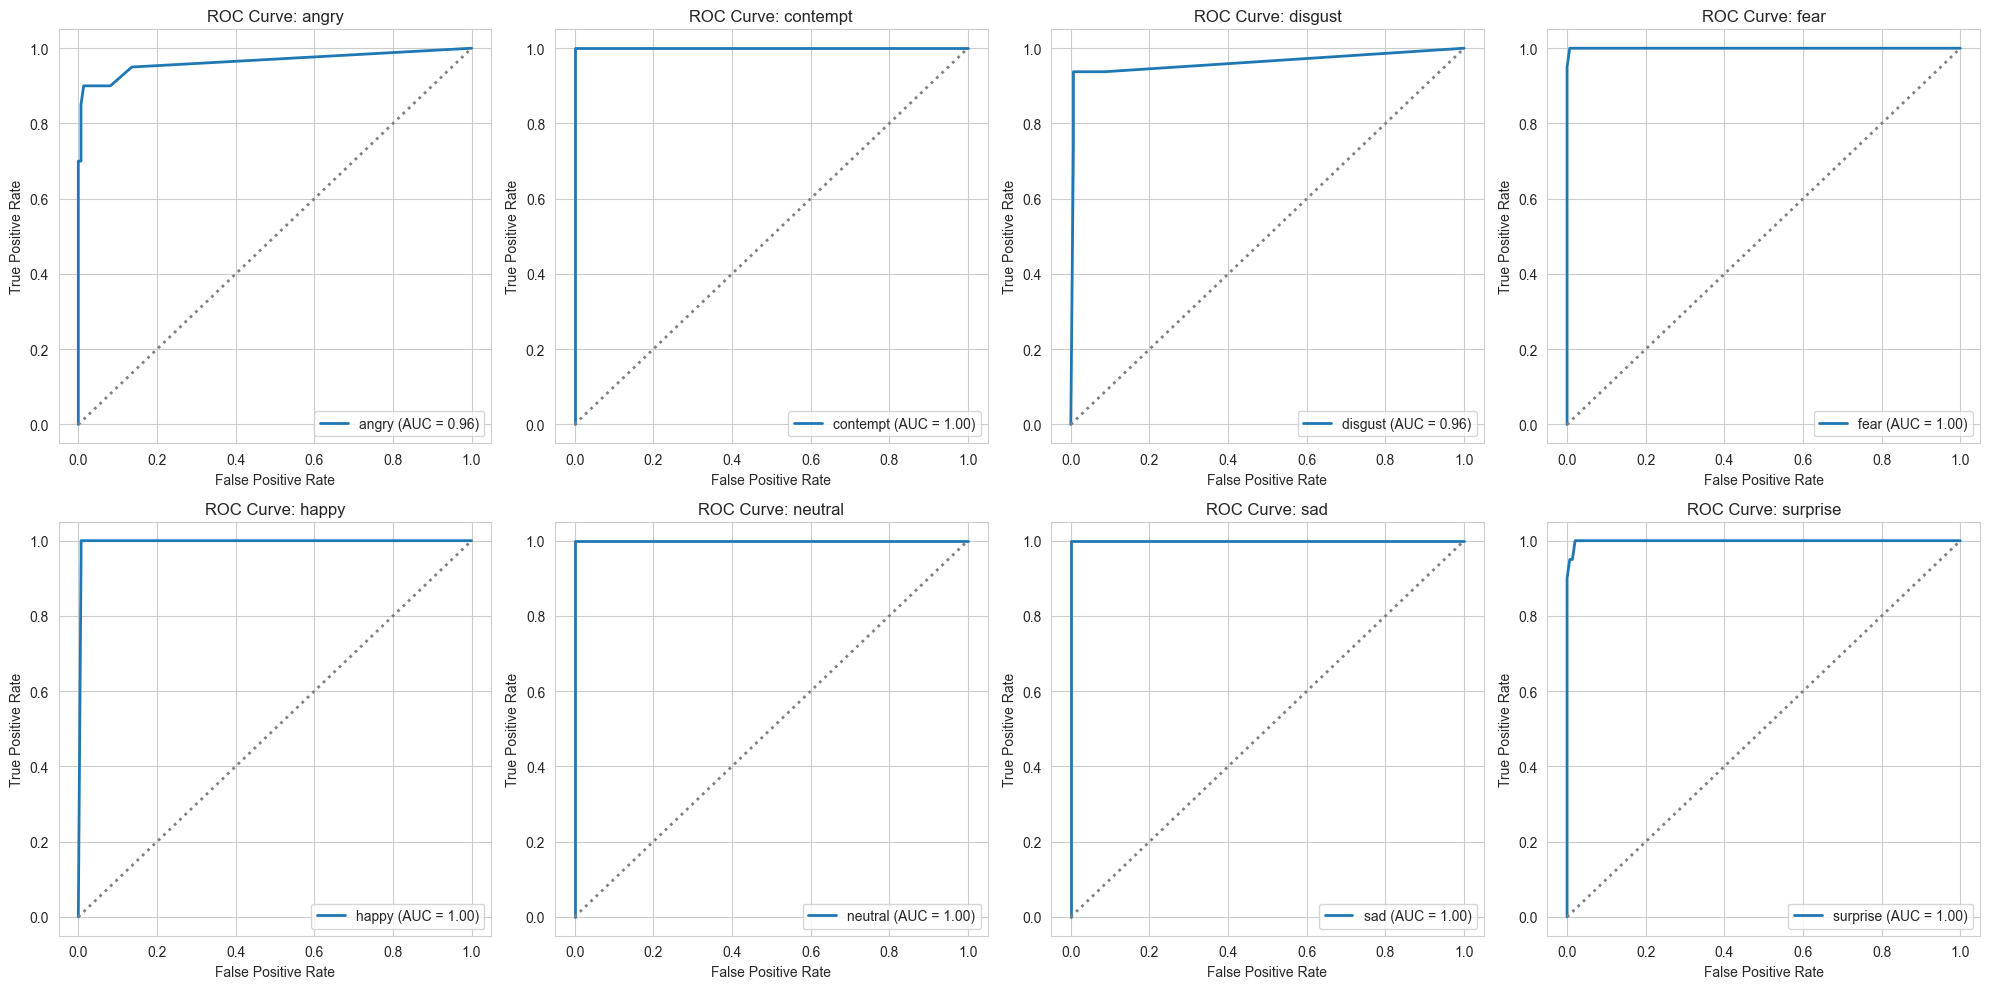

In [36]:
from pipelines.utils import plot_all_class_roc
stacked_test_probs = best_meta_learner.predict_proba(stacked_features_test)

roc_auc_scores = plot_all_class_roc(np.array(stacked_labels_test), stacked_test_probs, class_names=label_map, per_row=4)
